# Band Unfolding Tutorial

## Introduction to Band Unfolding

Band unfolding is a powerful technique used in electronic structure calculations to analyze the electronic properties of supercells by projecting their band structure back onto the primitive cell's Brillouin zone. This technique is essential when studying:

- **Defects and impurities**: When introducing point defects, you need to use supercells, but the resulting band structure is "folded" into a smaller Brillouin zone
- **Alloys and solid solutions**: Random or ordered arrangements often require supercell calculations
- **Surface and interface effects**: Slab models with large unit cells
- **Phonon-electron coupling**: Calculations with displaced atoms in supercells

## Why Do We Need Band Unfolding?

When you create a supercell (e.g., 2×2×2), the Brillouin zone becomes 1/8 the size of the primitive cell's Brillouin zone. The band structure calculated for the supercell contains:

1. **Genuine bands**: Bands that correspond to the primitive cell's electronic structure
2. **Folded bands**: Bands that are artifacts of the supercell periodicity

Band unfolding helps to:
- **Separate genuine bands from folded bands**
- **Recover the primitive cell's band structure** from supercell calculations
- **Identify which bands are most affected** by the supercell modifications (defects, disorder, etc.)

## The Physics Behind Unfolding

The unfolding process uses the **spectral weight function** to determine how much each supercell band contributes to the primitive cell's band structure. The spectral weight is calculated from the overlap between supercell and primitive cell Bloch states:

$$w_{n\mathbf{k}} = |\langle \psi_{n\mathbf{k}}^{SC} | \psi_{\mathbf{k}}^{PC} \rangle|^2$$

Where:
- $\psi_{n\mathbf{k}}^{SC}$ is the supercell Bloch state
- $\psi_{\mathbf{k}}^{PC}$ is the primitive cell Bloch state
- $w_{n\mathbf{k}}$ is the spectral weight (0 ≤ w ≤ 1)

High spectral weights (close to 1) indicate genuine bands, while low weights suggest folded bands.

---

In this tutorial, we'll explore PyProcar's band unfolding capabilities using MgB₂ as an example system.

## Setting Up the Environment and Data

First, let's import the necessary libraries and download the example data. We'll be working with MgB₂, which is an excellent example for band unfolding because:

- It has a relatively simple primitive cell structure
- The supercell shows clear folding effects  
- The band structure has interesting features around the Fermi level

In [1]:
# Import required libraries
from pathlib import Path
import numpy as np
import pyprocar

# Setup data directories
CURRENT_DIR = Path(".").resolve()
print(f"Current working directory: {CURRENT_DIR}")

# Download the example data for both primitive cell and supercell
UNFOLD_PATH = "data/examples/bands/unfolding"
pyprocar.download_from_hf(relpath=UNFOLD_PATH, output_path=CURRENT_DIR)

# Define data directories
primitive_dir = CURRENT_DIR / UNFOLD_PATH / "primitive"
supercell_dir = CURRENT_DIR / UNFOLD_PATH / "supercell"

print(f"Primitive cell data: {primitive_dir}")
print(f"Supercell data: {supercell_dir}")

# Verify the data exists
print(f"\nPrimitive cell files exist: {primitive_dir.exists()}")
print(f"Supercell files exist: {supercell_dir.exists()}")

Current working directory: C:\Users\lllang\Desktop\notebooks\Notebook\01 - Projects\Pyprocar\pyprocar\examples\00-band_structure
Data already exists at C:\Users\lllang\Desktop\notebooks\Notebook\01 - Projects\Pyprocar\pyprocar\examples\00-band_structure\data\examples\00-band_structure\unfolding
Primitive cell data: C:\Users\lllang\Desktop\notebooks\Notebook\01 - Projects\Pyprocar\pyprocar\examples\00-band_structure\data\examples\00-band_structure\unfolding\primitive
Supercell data: C:\Users\lllang\Desktop\notebooks\Notebook\01 - Projects\Pyprocar\pyprocar\examples\00-band_structure\data\examples\00-band_structure\unfolding\supercell

Primitive cell files exist: True
Supercell files exist: True


## Step 1: Understanding the Primitive Cell

Before we dive into unfolding, let's first examine the band structure of the primitive cell. This will serve as our reference point for understanding what the unfolded supercell bands should look like.

### Primitive Cell Band Structure

The primitive cell of MgB₂ has a simple hexagonal structure. Let's plot its band structure to see the "true" electronic structure that we want to recover from the supercell calculations.

If you want more detailed logs, set verbose to 2 or more
____________________________________________________________________________________________________
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Plotting bands in plain mode


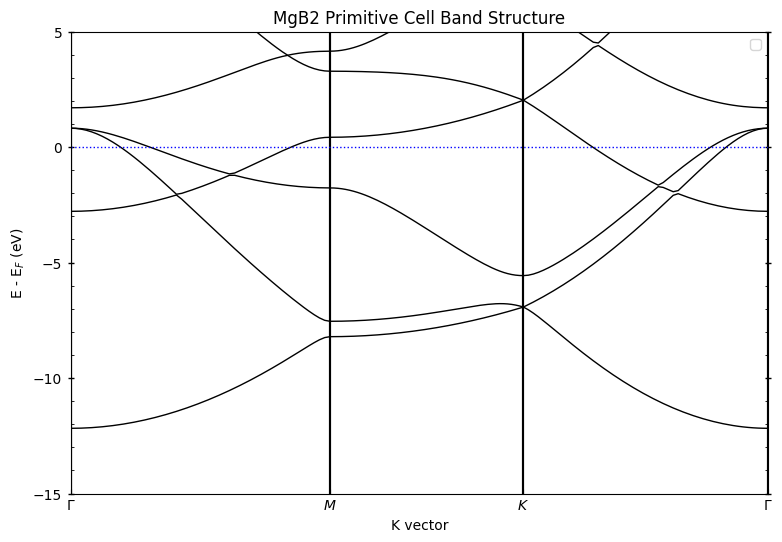

This is the reference band structure from the primitive cell.
Note the characteristic features around the Fermi level (0 eV).


In [2]:
# Plot the primitive cell band structure
# This shows the "reference" band structure that we want to recover from unfolding

pyprocar.bandsplot(
    code="vasp", 
    mode="plain", 
    fermi=4.993523, 
    elimit=[-15, 5], 
    dirname=primitive_dir,
    quiet_welcome=True,
    title="MgB2 Primitive Cell Band Structure"
)

print("This is the reference band structure from the primitive cell.")
print("Note the characteristic features around the Fermi level (0 eV).")

## Step 2: Basic Band Unfolding

Now we'll perform band unfolding on the supercell calculation. The supercell we're using is a 2×2×2 expansion of the primitive cell, which means:

- The supercell contains 8 times more atoms than the primitive cell
- The Brillouin zone is 1/8 the size of the primitive cell's BZ
- Each primitive band appears 8 times in the supercell (due to folding)

### Understanding the Supercell Matrix

The `transformation_matrix` (or `supercell_matrix`) defines how the supercell relates to the primitive cell:
- `np.diag([2, 2, 2])` means we have a 2×2×2 supercell
- This matrix is crucial for the unfolding algorithm to work correctly

### Basic Unfolding with "both" Mode

Let's start with the most comprehensive unfolding mode called "both", which shows spectral weights through both line thickness and color intensity.

If you want more detailed logs, set verbose to 2 or more
____________________________________________________________________________________________________
 ____        ____
|  _ \ _   _|  _ \ _ __ ___   ___ __ _ _ __ 
| |_) | | | | |_) | '__/ _ \ / __/ _` | '__|
|  __/| |_| |  __/| | | (_) | (_| (_| | |   
|_|    \__, |_|   |_|  \___/ \___\__,_|_|
       |___/
A Python library for electronic structure pre/post-processing.

Version 6.4.6 created on Mar 6th, 2025

Please cite:
- Uthpala Herath, Pedram Tavadze, Xu He, Eric Bousquet, Sobhit Singh, Francisco Muñoz and Aldo Romero.,
  PyProcar: A Python library for electronic structure pre/post-processing.,
  Computer Physics Communications 251, 107080 (2020).

- L. Lang, P. Tavadze, A. Tellez, E. Bousquet, H. Xu, F. Muñoz, N. Vasquez, U. Herath, and A. H. Romero,
  Expanding PyProcar for new features, maintainability, and reliability.,
  Computer Physics Communications 297, 109063 (2024).

Developers:
- Francisco Muñoz
- Aldo Romero
- So

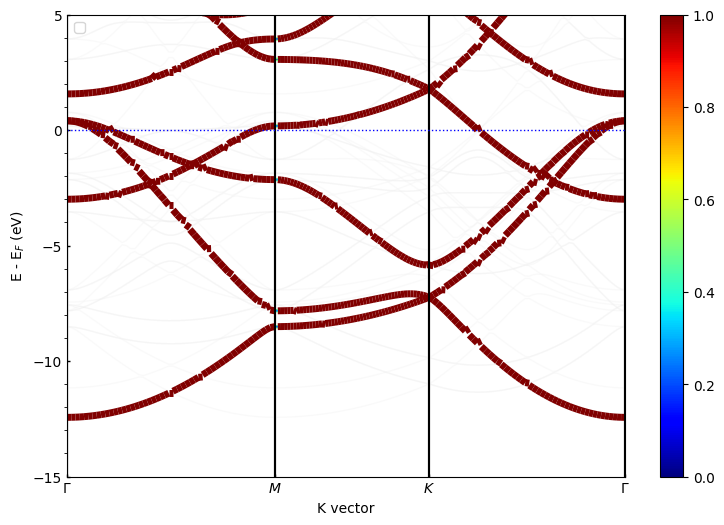

In this plot:
- Thick, bright lines = high spectral weight (genuine bands)
- Thin, faded lines = low spectral weight (folded bands)
- Compare this with the primitive cell plot above!


In [3]:

# Perform band unfolding with "both" mode
# This shows spectral weights through both line thickness and color intensity

pyprocar.unfold(
    code="vasp",
    mode="plain",
    unfold_mode="both",
    fermi=5.033090,
    dirname=supercell_dir,
    elimit=[-15, 5],
    transformation_matrix=np.diag([2, 2, 2]),
    title="MgB₂ Unfolded Band Structure (Both Mode)"
)

print("In this plot:")
print("- Thick, bright lines = high spectral weight (genuine bands)")
print("- Thin, faded lines = low spectral weight (folded bands)")
print("- Compare this with the primitive cell plot above!")

## Step 3: Exploring Different Unfolding Modes

PyProcar offers different ways to visualize the spectral weights through the `unfold_mode` parameter. Let's explore each mode to understand their strengths and use cases.

### Thickness Mode

In thickness mode, the spectral weight is represented only by the line thickness. This is useful when you want to focus purely on the band structure without color distractions.


If you want more detailed logs, set verbose to 2 or more
____________________________________________________________________________________________________
 ____        ____
|  _ \ _   _|  _ \ _ __ ___   ___ __ _ _ __ 
| |_) | | | | |_) | '__/ _ \ / __/ _` | '__|
|  __/| |_| |  __/| | | (_) | (_| (_| | |   
|_|    \__, |_|   |_|  \___/ \___\__,_|_|
       |___/
A Python library for electronic structure pre/post-processing.

Version 6.4.6 created on Mar 6th, 2025

Please cite:
- Uthpala Herath, Pedram Tavadze, Xu He, Eric Bousquet, Sobhit Singh, Francisco Muñoz and Aldo Romero.,
  PyProcar: A Python library for electronic structure pre/post-processing.,
  Computer Physics Communications 251, 107080 (2020).

- L. Lang, P. Tavadze, A. Tellez, E. Bousquet, H. Xu, F. Muñoz, N. Vasquez, U. Herath, and A. H. Romero,
  Expanding PyProcar for new features, maintainability, and reliability.,
  Computer Physics Communications 297, 109063 (2024).

Developers:
- Francisco Muñoz
- Aldo Romero
- So

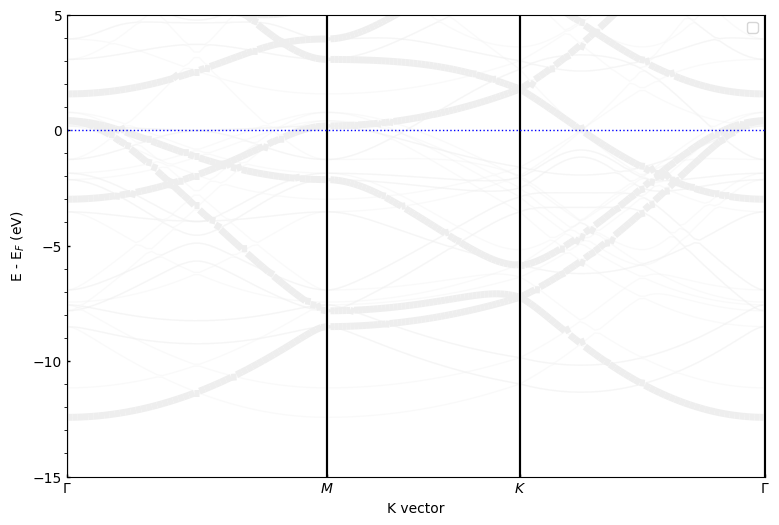

Thickness mode advantages:
- Clean, minimalist appearance
- Easy to distinguish genuine vs folded bands
- Good for black and white publications


In [4]:
# Unfolding with thickness mode only
pyprocar.unfold(
    code="vasp",
    mode="plain",
    unfold_mode="thickness",
    fermi=5.033090,
    dirname=supercell_dir,
    elimit=[-15, 5],
    transformation_matrix=np.diag([2, 2, 2]),
    title="MgB₂ Unfolded Band Structure (Thickness Mode)"
)

print("Thickness mode advantages:")
print("- Clean, minimalist appearance")
print("- Easy to distinguish genuine vs folded bands")
print("- Good for black and white publications")


### Color Mode

In color mode, the spectral weight is represented through color intensity while keeping line thickness constant. This mode provides excellent visual contrast and is particularly effective for identifying subtle differences in spectral weights.


If you want more detailed logs, set verbose to 2 or more
____________________________________________________________________________________________________
 ____        ____
|  _ \ _   _|  _ \ _ __ ___   ___ __ _ _ __ 
| |_) | | | | |_) | '__/ _ \ / __/ _` | '__|
|  __/| |_| |  __/| | | (_) | (_| (_| | |   
|_|    \__, |_|   |_|  \___/ \___\__,_|_|
       |___/
A Python library for electronic structure pre/post-processing.

Version 6.4.6 created on Mar 6th, 2025

Please cite:
- Uthpala Herath, Pedram Tavadze, Xu He, Eric Bousquet, Sobhit Singh, Francisco Muñoz and Aldo Romero.,
  PyProcar: A Python library for electronic structure pre/post-processing.,
  Computer Physics Communications 251, 107080 (2020).

- L. Lang, P. Tavadze, A. Tellez, E. Bousquet, H. Xu, F. Muñoz, N. Vasquez, U. Herath, and A. H. Romero,
  Expanding PyProcar for new features, maintainability, and reliability.,
  Computer Physics Communications 297, 109063 (2024).

Developers:
- Francisco Muñoz
- Aldo Romero
- So

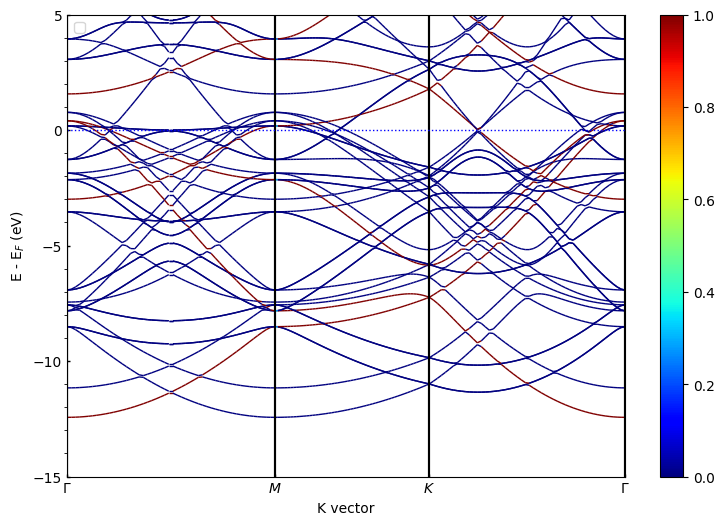

Color mode advantages:
- Excellent visual contrast
- Good for presentations and colored figures
- Color scale shows quantitative spectral weights


In [5]:
# Unfolding with color mode only
pyprocar.unfold(
    code="vasp",
    mode="plain",
    unfold_mode="color",
    fermi=5.033090,
    dirname=supercell_dir,
    elimit=[-15, 5],
    transformation_matrix=np.diag([2, 2, 2]),
    title="MgB₂ Unfolded Band Structure (Color Mode)"
)

print("Color mode advantages:")
print("- Excellent visual contrast")
print("- Good for presentations and colored figures") 
print("- Color scale shows quantitative spectral weights")


## Step 4: Advanced Unfolding with Projections

Beyond basic unfolding, PyProcar allows you to combine unfolding with orbital and atomic projections. This is extremely powerful for understanding which atoms or orbitals contribute to specific bands.

### Parametric Mode with Unfolding

Parametric mode combines unfolding with orbital/atomic projections, allowing you to see both the spectral weights and the orbital character simultaneously.


If you want more detailed logs, set verbose to 2 or more
____________________________________________________________________________________________________
 ____        ____
|  _ \ _   _|  _ \ _ __ ___   ___ __ _ _ __ 
| |_) | | | | |_) | '__/ _ \ / __/ _` | '__|
|  __/| |_| |  __/| | | (_) | (_| (_| | |   
|_|    \__, |_|   |_|  \___/ \___\__,_|_|
       |___/
A Python library for electronic structure pre/post-processing.

Version 6.4.6 created on Mar 6th, 2025

Please cite:
- Uthpala Herath, Pedram Tavadze, Xu He, Eric Bousquet, Sobhit Singh, Francisco Muñoz and Aldo Romero.,
  PyProcar: A Python library for electronic structure pre/post-processing.,
  Computer Physics Communications 251, 107080 (2020).

- L. Lang, P. Tavadze, A. Tellez, E. Bousquet, H. Xu, F. Muñoz, N. Vasquez, U. Herath, and A. H. Romero,
  Expanding PyProcar for new features, maintainability, and reliability.,
  Computer Physics Communications 297, 109063 (2024).

Developers:
- Francisco Muñoz
- Aldo Romero
- So

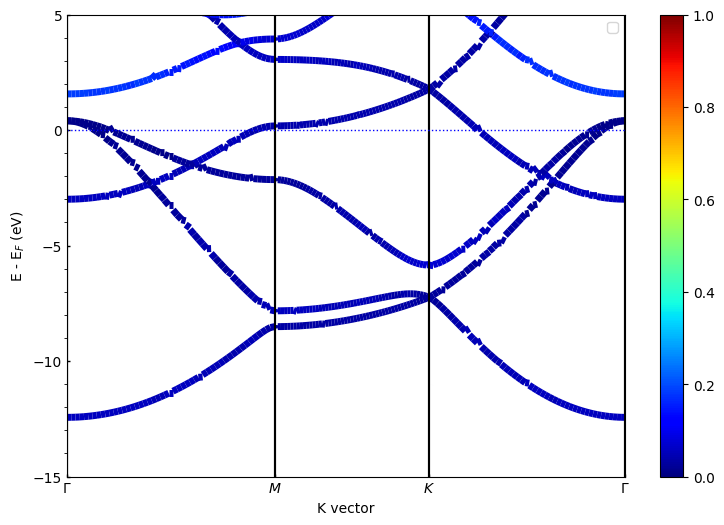

In this plot:
- Line thickness = spectral weight (unfolding)
- Color intensity = Mg orbital contributions
- You can identify which bands have Mg character!


In [6]:
# Parametric unfolding: showing Mg contributions
# Here we see both unfolding weights (line thickness) and Mg projections (color)
pyprocar.unfold(
    code="vasp",
    mode="parametric",
    unfold_mode="thickness",  # Use thickness for unfolding weights
    atoms=np.arange(0, 8),             # Project onto Mg atoms
    fermi=5.033090,
    dirname=supercell_dir,
    elimit=[-15, 5],
    transformation_matrix=np.diag([2, 2, 2]),
    title="MgB₂ Unfolded Bands with Mg Projections"
)

print("In this plot:")
print("- Line thickness = spectral weight (unfolding)")
print("- Color intensity = Mg orbital contributions")
print("- You can identify which bands have Mg character!")


If you want more detailed logs, set verbose to 2 or more
____________________________________________________________________________________________________
 ____        ____
|  _ \ _   _|  _ \ _ __ ___   ___ __ _ _ __ 
| |_) | | | | |_) | '__/ _ \ / __/ _` | '__|
|  __/| |_| |  __/| | | (_) | (_| (_| | |   
|_|    \__, |_|   |_|  \___/ \___\__,_|_|
       |___/
A Python library for electronic structure pre/post-processing.

Version 6.4.6 created on Mar 6th, 2025

Please cite:
- Uthpala Herath, Pedram Tavadze, Xu He, Eric Bousquet, Sobhit Singh, Francisco Muñoz and Aldo Romero.,
  PyProcar: A Python library for electronic structure pre/post-processing.,
  Computer Physics Communications 251, 107080 (2020).

- L. Lang, P. Tavadze, A. Tellez, E. Bousquet, H. Xu, F. Muñoz, N. Vasquez, U. Herath, and A. H. Romero,
  Expanding PyProcar for new features, maintainability, and reliability.,
  Computer Physics Communications 297, 109063 (2024).

Developers:
- Francisco Muñoz
- Aldo Romero
- So

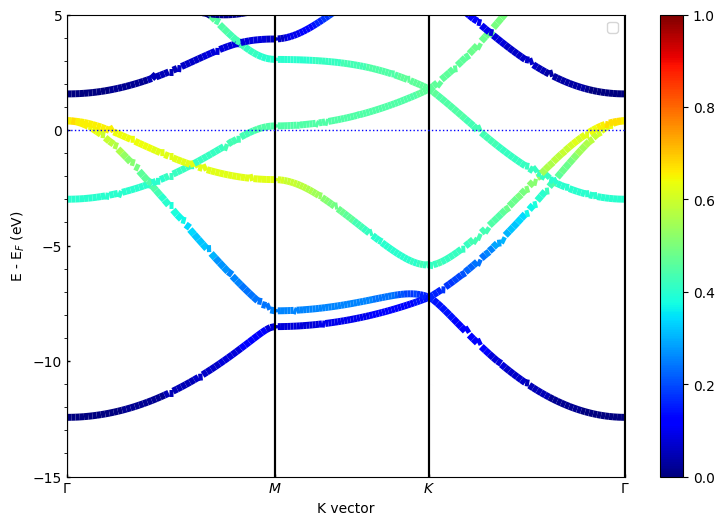

B p-orbitals are responsible for:
- The conduction bands near the Fermi level
- The superconducting properties of MgB₂
- Notice how different this looks from the Mg projection!


In [7]:
# Parametric unfolding: showing B orbital contributions
# Let's examine the B p-orbitals which are crucial for the electronic properties
pyprocar.unfold(
    code="vasp",
    mode="parametric",
    unfold_mode="thickness",
    atoms=np.arange(8,24),
    orbitals=[1,2,3],          # Focus on p orbitals
    fermi=5.033090,
    dirname=supercell_dir,
    elimit=[-15, 5],
    transformation_matrix=np.diag([2, 2, 2]),
    title="MgB₂ Unfolded Bands with B p-orbital Projections"
)

print("B p-orbitals are responsible for:")
print("- The conduction bands near the Fermi level")
print("- The superconducting properties of MgB₂")
print("- Notice how different this looks from the Mg projection!")


### Overlay Modes

PyProcar provides several overlay modes that show multiple projections simultaneously. This is particularly useful for comparing different atomic or orbital contributions in the unfolded band structure.

#### Overlay by Species

If you want more detailed logs, set verbose to 2 or more
____________________________________________________________________________________________________
 ____        ____
|  _ \ _   _|  _ \ _ __ ___   ___ __ _ _ __ 
| |_) | | | | |_) | '__/ _ \ / __/ _` | '__|
|  __/| |_| |  __/| | | (_) | (_| (_| | |   
|_|    \__, |_|   |_|  \___/ \___\__,_|_|
       |___/
A Python library for electronic structure pre/post-processing.

Version 6.4.6 created on Mar 6th, 2025

Please cite:
- Uthpala Herath, Pedram Tavadze, Xu He, Eric Bousquet, Sobhit Singh, Francisco Muñoz and Aldo Romero.,
  PyProcar: A Python library for electronic structure pre/post-processing.,
  Computer Physics Communications 251, 107080 (2020).

- L. Lang, P. Tavadze, A. Tellez, E. Bousquet, H. Xu, F. Muñoz, N. Vasquez, U. Herath, and A. H. Romero,
  Expanding PyProcar for new features, maintainability, and reliability.,
  Computer Physics Communications 297, 109063 (2024).

Developers:
- Francisco Muñoz
- Aldo Romero
- So

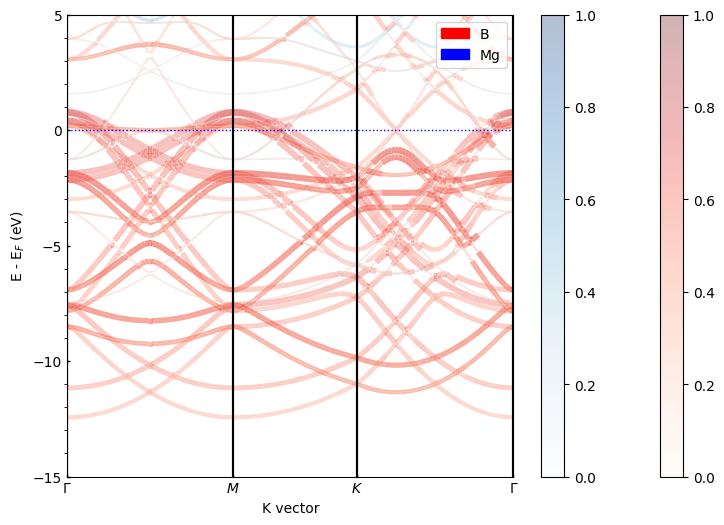

Species overlay shows:
- Different colors for different elements (Mg vs B)
- Line thickness still represents spectral weights
- Legend helps identify which bands belong to which atoms


In [8]:
# Overlay species mode: Compare Mg vs B contributions
pyprocar.unfold(
    code="vasp",
    mode="overlay_species",
    unfold_mode="thickness",
    fermi=5.033090,
    dirname=supercell_dir,
    elimit=[-15, 5],
    transformation_matrix=np.diag([2, 2, 2]),
    title="MgB₂ Unfolded Bands - Species Overlay"
)

print("Species overlay shows:")
print("- Different colors for different elements (Mg vs B)")
print("- Line thickness still represents spectral weights") 
print("- Legend helps identify which bands belong to which atoms")


#### Overlay by Orbitals


If you want more detailed logs, set verbose to 2 or more
____________________________________________________________________________________________________
 ____        ____
|  _ \ _   _|  _ \ _ __ ___   ___ __ _ _ __ 
| |_) | | | | |_) | '__/ _ \ / __/ _` | '__|
|  __/| |_| |  __/| | | (_) | (_| (_| | |   
|_|    \__, |_|   |_|  \___/ \___\__,_|_|
       |___/
A Python library for electronic structure pre/post-processing.

Version 6.4.6 created on Mar 6th, 2025

Please cite:
- Uthpala Herath, Pedram Tavadze, Xu He, Eric Bousquet, Sobhit Singh, Francisco Muñoz and Aldo Romero.,
  PyProcar: A Python library for electronic structure pre/post-processing.,
  Computer Physics Communications 251, 107080 (2020).

- L. Lang, P. Tavadze, A. Tellez, E. Bousquet, H. Xu, F. Muñoz, N. Vasquez, U. Herath, and A. H. Romero,
  Expanding PyProcar for new features, maintainability, and reliability.,
  Computer Physics Communications 297, 109063 (2024).

Developers:
- Francisco Muñoz
- Aldo Romero
- So

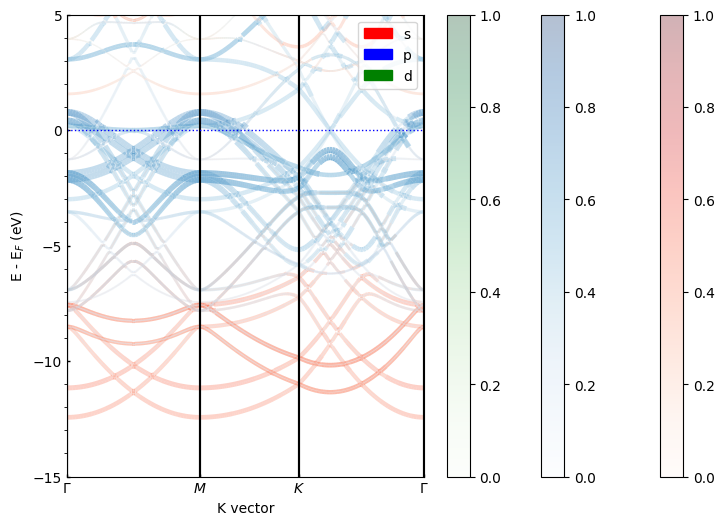

Orbital overlay reveals:
- s-orbital contributions (typically lower in energy)
- p-orbital contributions (important near Fermi level)
- d-orbital contributions (if present)
- How different orbitals contribute to different energy ranges


In [9]:
# Overlay orbitals mode: Compare s, p, d orbital contributions
pyprocar.unfold(
    code="vasp",
    mode="overlay_orbitals",
    unfold_mode="thickness",
    fermi=5.033090,
    dirname=supercell_dir,
    elimit=[-15, 5],
    transformation_matrix=np.diag([2, 2, 2]),
    title="MgB₂ Unfolded Bands - Orbital Overlay"
)

print("Orbital overlay reveals:")
print("- s-orbital contributions (typically lower in energy)")
print("- p-orbital contributions (important near Fermi level)")  
print("- d-orbital contributions (if present)")
print("- How different orbitals contribute to different energy ranges")


## Step 5: Scatter Plot Mode

Sometimes it's useful to visualize the unfolded bands as scatter plots rather than line plots. This can help identify the discrete nature of the spectral weights and make certain features more visible.


If you want more detailed logs, set verbose to 2 or more
____________________________________________________________________________________________________
 ____        ____
|  _ \ _   _|  _ \ _ __ ___   ___ __ _ _ __ 
| |_) | | | | |_) | '__/ _ \ / __/ _` | '__|
|  __/| |_| |  __/| | | (_) | (_| (_| | |   
|_|    \__, |_|   |_|  \___/ \___\__,_|_|
       |___/
A Python library for electronic structure pre/post-processing.

Version 6.4.6 created on Mar 6th, 2025

Please cite:
- Uthpala Herath, Pedram Tavadze, Xu He, Eric Bousquet, Sobhit Singh, Francisco Muñoz and Aldo Romero.,
  PyProcar: A Python library for electronic structure pre/post-processing.,
  Computer Physics Communications 251, 107080 (2020).

- L. Lang, P. Tavadze, A. Tellez, E. Bousquet, H. Xu, F. Muñoz, N. Vasquez, U. Herath, and A. H. Romero,
  Expanding PyProcar for new features, maintainability, and reliability.,
  Computer Physics Communications 297, 109063 (2024).

Developers:
- Francisco Muñoz
- Aldo Romero
- So

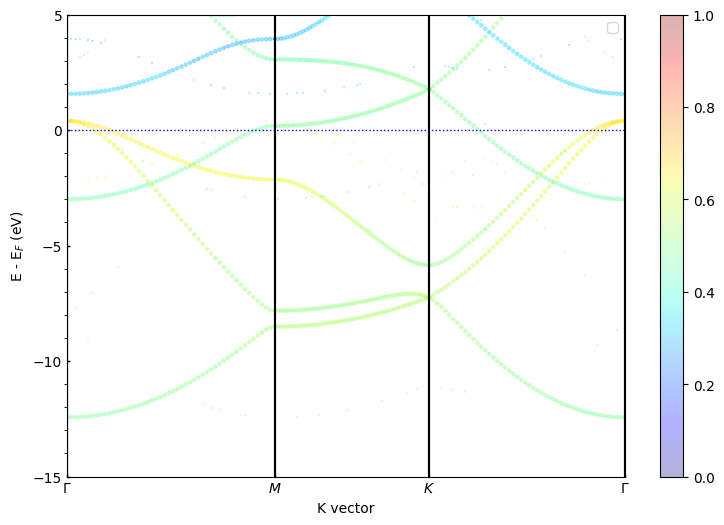

Scatter plot advantages:
- Shows discrete nature of calculated k-points
- Point size represents spectral weights
- Easier to see individual band crossings
- Good for identifying band gaps and degeneracies


In [10]:
# Scatter plot unfolding
pyprocar.unfold(
    code="vasp",
    mode="scatter",
    unfold_mode="both",     # Both size and color represent spectral weights
    fermi=5.033090,
    dirname=supercell_dir,
    elimit=[-15, 5],
    transformation_matrix=np.diag([2, 2, 2]),
    title="MgB₂ Unfolded Bands - Scatter Plot"
)

print("Scatter plot advantages:")
print("- Shows discrete nature of calculated k-points")
print("- Point size represents spectral weights") 
print("- Easier to see individual band crossings")
print("- Good for identifying band gaps and degeneracies")


## Summary and Key Takeaways

### What We've Learned

1. **Band unfolding** is essential for interpreting supercell band structure calculations
2. **Spectral weights** distinguish genuine bands from folded artifacts
3. **Different visualization modes** provide complementary insights:
   - Plain unfolding for basic analysis
   - Parametric modes for orbital/atomic analysis
   - Overlay modes for comparing contributions
   - Scatter plots for detailed k-point analysis

### Physical Insights from MgB₂

From our unfolding analysis of MgB₂, we can identify:
- **Mg contributions**: Primarily in deeper valence bands
- **B p-orbital character**: Dominates near the Fermi level
- **Band dispersion**: Successfully recovered from the supercell
- **Electronic structure**: Consistent with known MgB₂ properties

### Applications in Research

Band unfolding is particularly valuable for:
- **Defect studies**: Identifying defect-induced states
- **Alloy analysis**: Understanding compositional disorder effects
- **Surface science**: Analyzing slab calculations
- **Pressure/strain studies**: Examining structural modifications
- **Electron-phonon coupling**: Studying displaced atomic configurations

### Next Steps

For your own research:
1. Always compare unfolded results with primitive cell calculations
2. Use appropriate energy windows for your specific questions
3. Combine different modes to get complete picture
4. Pay attention to spectral weights for physical interpretation
5. Validate results against experimental data when available

**Happy band unfolding with PyProcar!**
